In [ ]:
from src.networks.speech_separation import SpeechbrainSepformer
from src.dataset import LibriWHAM
from torchmetrics.functional import scale_invariant_signal_distortion_ratio
import torch

dataset = LibriWHAM(length_seconds=4.096, train=False, return_pair=True)
x0, x1 = dataset[0]
x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)
model = SpeechbrainSepformer()
with torch.no_grad():
    out = model.separate(x1)

from IPython.display import Audio, display  
display(Audio(x1.squeeze().numpy(), rate=16000))
display(Audio(out.squeeze().detach().numpy(), rate=16000, normalize=False))

sisdri = scale_invariant_signal_distortion_ratio(out, x0, zero_mean=True) - scale_invariant_signal_distortion_ratio(x1, x0, zero_mean=True)
print(sisdri)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached


Setting SNR range to -2 to 5 dB for LibriWHAM test set


INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: encoder, masknet, decoder
/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default valu

Loaded SpeechbrainSepformer from sepformer-wham16k-enhancement with 25613569 parameters.


tensor([[8.2255]])


/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `scale_invariant_signal_distortion_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `scale_invariant_signal_distortion_ratio` from `torchmetrics.audio` instead.
  _future_warning(


In [22]:
scale_invariant_signal_distortion_ratio(out, x0, zero_mean=True)

tensor([[9.1098]])

In [23]:
"""
Heuristic dereverberation using WPE.
Based on https://github.com/fgnt/nara_wpe/tree/master
and https://www.audiolabs-erlangen.de/media/pages/resources/aps-w23/papers/259461a00d-1663358899/sap_Yoshioka2012.pdf
"""

from nara_wpe.utils import stft, istft, get_stft_center_frequencies
import torch
from nara_wpe.wpe import wpe

class WPE:
    def __init__(self):
        self.taps = 10
        self.delay = 3
        self.iterations = 5
        self.stft_size=512
        self.stft_shift=128
        
    def encode(self, x : torch.Tensor) -> torch.Tensor: return x
    def decode(self, x : torch.Tensor) -> torch.Tensor: return x
    def to(self, device : str) -> None: ...
    
    def dereverb(self, audio : torch.Tensor) -> torch.Tensor:
        device = audio.device
        processed = []
        
        for frame in audio:
            frame = frame.cpu().numpy()
            Y = stft(frame, self.stft_size, self.stft_shift)
            Y = Y.transpose(2, 0, 1)
            Z = wpe(Y, taps=self.taps, delay=self.delay, iterations=self.iterations, statistics_mode='full')
            dereverb = istft(Z.transpose(1, 2, 0), size=self.stft_size, shift=self.stft_shift)
            processed.append(torch.tensor(dereverb, device=device))

        processed = torch.stack(processed).to(device)
        return processed

In [ ]:
from torch.utils.data import Dataset
from src.dataset import ClippedLibri, LibriRIR, LibriWHAM
import torch
import os

def make_test_dataset(dataset : Dataset, num_samples : int, path : str):
    os.makedirs(path, exist_ok=True)
    
    for i in range(num_samples):
        x0, x1 = dataset[i]
        data = {"x0": x0, "x1": x1}
        torch.save(data, path + f"/batch_{i}")

what_test = "noise"
sample_rate = 16000

if what_test == "clip":
    dataset = ClippedLibri(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)
    gain_db = dataset.what_db_for_snr(target_snr=2.0)
    dataset.gain_min, dataset.gain_max = gain_db, gain_db
    
elif what_test == "rir":
    dataset = LibriRIR(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)

elif what_test == 'noise':
    dataset = LibriWHAM(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)


path = f"/work3/s214630/data/{what_test}"
# make_test_dataset(dataset, 512, path)

Setting SNR range to -2 to 5 dB for LibriWHAM test set


In [2]:
from src.dataset import AllLibri
dataset = AllLibri(length_seconds=4.096, sample_rate=16000, train=False)
import torch
from src.callbacks.utils import get_batch_from_dataset
# batch = get_batch_from_dataset(dataset, 5, shuffle=False)
batch = torch.randn(1, 1, int(16_000 * 10))
from src.networks.encoders import HifiGan
import torch

encoder = HifiGan()
with torch.no_grad():
    encoded = encoder.encode(batch)
    decoded = encoder.decode(encoded)

In [13]:
import torchaudio
for i in range(batch.size(0)):
    audio = torch.cat([
        batch[i].flatten(),
        decoded[i].flatten(),
    ], dim=0)
    torchaudio.save(f"samples/reconstruction_{i}.wav", audio.unsqueeze(0).cpu(), 16000)

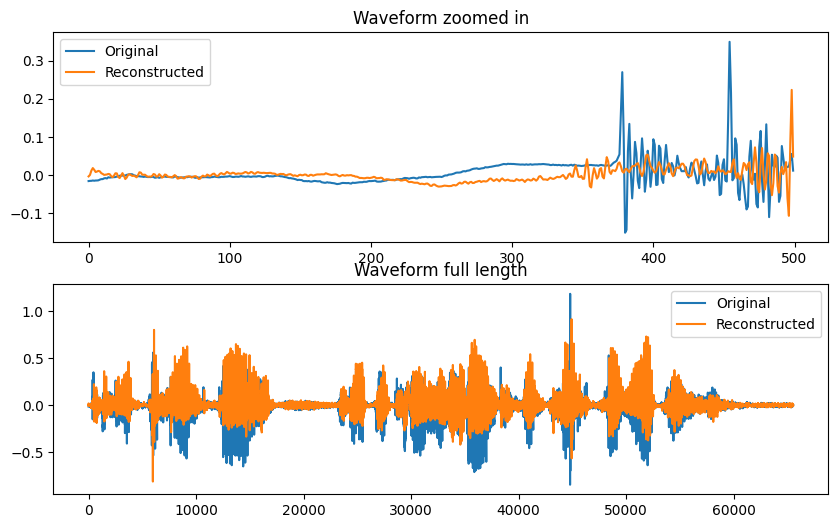

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs : list[plt.Axes]
N = 500
axs[0].plot(batch[0, 0, :N], label="Original")
axs[0].plot(decoded[0, 0, :N], label="Reconstructed")
axs[0].legend()
axs[0].set_title("Waveform zoomed in")

axs[1].plot(batch[0, 0, :], label="Original")
axs[1].plot(decoded[0, 0, :], label="Reconstructed")
axs[1].legend()
axs[1].set_title("Waveform full length")


plt.show()